<a href="https://colab.research.google.com/github/jfvandem/dev_test_days/blob/master/intro_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dev test days 2019 - Meylan

basé sur https://www.kaggle.com/c/ashrae-energy-prediction/data

https://www.tensorflow.org/tutorials/keras/regression
https://www.tensorflow.org/tutorials/structured_data/time_series
https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series


# Clone github

In [1]:
!rm -rf dev_test_days
!git clone https://github.com/jfvandem/dev_test_days

Cloning into 'dev_test_days'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 187 (delta 60), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (187/187), 132.73 MiB | 55.63 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


# Import

In [0]:
import gc
import glob
import io
import itertools
import joblib
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import re
import requests
import seaborn as sns
import tensorflow as tf
import time
import warnings
import zipfile

from math import sqrt
from matplotlib.collections import PatchCollection
from os import path

from scipy import stats
from scipy.stats import skew

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

warnings.filterwarnings("ignore")

In [52]:
print(tf.__version__)

2.0.0


In [0]:
RANDOM_SEED = 42

tf.random.set_seed(RANDOM_SEED)

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Chargement des données

In [7]:
!ls dev_test_days

dataset  intro_deep_learning.ipynb  README.md


In [0]:
data_dir='dev_test_days/dataset/'

In [9]:
df = pd.read_pickle(data_dir+'train_full_df.pkl.zip',compression='zip')
df.shape
df.head()

(6634879, 23)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
6,6,0,2016-01-01,0.0,0,4,27926,1981,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
7,7,0,2016-01-01,0.0,0,0,121074,1989,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1
9,9,0,2016-01-01,0.0,0,6,27000,2010,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1


In [10]:
le=joblib.load(data_dir+'label_encoder.pkl')
le.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Retail', 'Services',
       'Technology/science', 'Utility', 'Warehouse/storage'], dtype=object)

In [0]:
df['primary_use_label']=le.inverse_transform(df['primary_use'])

In [12]:
len(df.columns)
df.columns

24

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'primary_use_label'],
      dtype='object')

#Echantillonnage
Nous sélectionnons les batiments pour que l'apprentissage du modèle soit réalisé dans un temps raisonnable. Nous conservons uniquement les mesures réalisées sur le compteur d'électricité

In [13]:
df['primary_use_label'].drop_duplicates()

0                           Education
6                 Lodging/residential
9                              Office
42                             Retail
49                            Parking
144                   Public services
170     Entertainment/public assembly
178                 Warehouse/storage
214            Food sales and service
228                 Religious worship
278                        Healthcare
442                           Utility
665                             Other
1235                         Services
1407               Technology/science
2120         Manufacturing/industrial
Name: primary_use_label, dtype: object

In [14]:
df.shape
df=df[(df['primary_use_label']=='Office')&(df['meter']==0)&(df['meter_reading']!=0))]
df.shape

(6634879, 24)

(806695, 24)

In [15]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime,primary_use_label
91,93,0,2016-01-01,52.420601,0,6,33370,1982,-1,25,6,20,-1,1019,0,0.0,1,53,1,0,4,1,1,Office
148,140,0,2016-01-01,8.020400,1,6,50020,-1,11,3,-1,2,-1,1020,11,3.1,1,53,1,0,4,1,1,Office
149,141,0,2016-01-01,20.648001,1,6,44789,1919,5,3,-1,2,-1,1020,11,3.1,1,53,1,0,4,1,1,Office
150,142,0,2016-01-01,13.377600,1,6,45348,-1,4,3,-1,2,-1,1020,11,3.1,1,53,1,0,4,1,1,Office
151,143,0,2016-01-01,15.500000,1,6,40085,-1,4,3,-1,2,-1,1020,11,3.1,1,53,1,0,4,1,1,Office


In [16]:
top_building_id=df.groupby('building_id')['meter_reading'].count().sort_values(ascending=False).reset_index().head(1)['building_id']
top_building_id

0    142
Name: building_id, dtype: uint64

In [17]:
df.shape
df=df[df['building_id'].isin(top_building_id)]
df.shape

(806695, 24)

(8784, 24)

In [18]:
df['meter'].value_counts()

0    8784
Name: meter, dtype: int64

In [19]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2016-01-01 00:00:00
2016-12-31 23:00:00


In [20]:
print('fréquence des mesures : {}'.format(df.groupby('timestamp')['meter_reading'].mean().index.inferred_freq))

fréquence des mesures : H


# Description des colonnes


* air_temperature : température de l'air (degré Celsius)
* building_id : foreign key pour les données sur les immeubles (building_metadata)
* cloud_coverage : couverture nuageuse (oktas)
* dew température : température de rosée (degré Celsius)
* floor_count : nombre d'étages dans l'immeuble
* meter : code du type de compteur {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Tous les immeubles n'ont pas tous les types de compteur
* meter_reading : Consommation d'énergie en kWh (avec erreurs de mesure possibles) (la "**target**")
* precip_depth_1_hr : hauteur de précipitation en 1h (millimètre)
* primary_use : indicateur de l'activité des occupants dans l'immeuble selon la définition EnergyStar
* sea_level_pressure : pression au niveau de la mer (Millibar/hectopascals)
* site_id : foreign key pour les données météo
* square_feet : surface au plancher de l'immeuble (pied carré)
* timestamp : date à laquelle la mesure a été prise. Le timestamp a été "éclaté" en plusieurs champs (heure, jour, année, jour dans la semaine...)
* wind_direction : direction du vent (0 à 360 degré)
* wind_speed : vitesse du vent (m/s)
* year_built : année de construction de l'immeuble



In [21]:
# Valeurs manquantes (substitution réalisée dans le preprocessing, -1 ou moyenne)
df.isna().sum()

building_id            0
meter                  0
timestamp              0
meter_reading          0
site_id                0
primary_use            0
square_feet            0
year_built             0
floor_count            0
air_temperature        0
cloud_coverage         0
dew_temperature        0
precip_depth_1_hr      0
sea_level_pressure     0
wind_direction         0
wind_speed             0
month_datetime         0
weekofyear_datetime    0
dayofyear_datetime     0
hour_datetime          0
day_week               0
day_month_datetime     0
week_month_datetime    0
primary_use_label      0
dtype: int64

#Data Visualisation

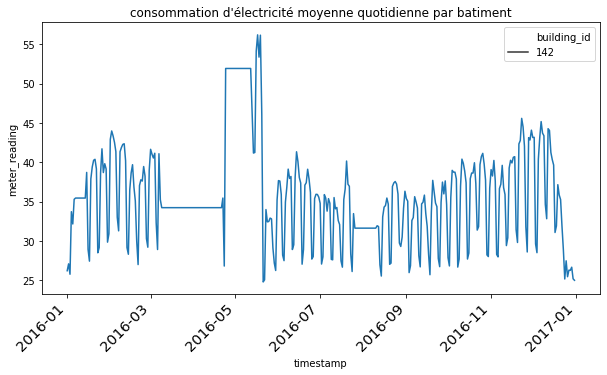

In [22]:

d=df.set_index('timestamp').groupby(['building_id']).resample('D')['meter_reading'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x='timestamp',y='meter_reading',data=d,style='building_id',palette='ch:2.5,.25').set_title('consommation d\'électricité moyenne quotidienne par batiment')

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
);



# Features

In [0]:
feature_cols=['primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'month_datetime',
 'weekofyear_datetime',
 'dayofyear_datetime',
 'hour_datetime',
 'day_week',
 'day_month_datetime',
 'week_month_datetime']
target_col='meter_reading'

#Train / test split

In [24]:
train_df=df[df['timestamp'].dt.month<11]
test_df=df[df['timestamp'].dt.month>=11]

train_df.shape
test_df.shape

(7320, 24)

(1464, 24)

#Normalisation des données

cf. https://jovianlin.io/why-is-normalization-important-in-neural-networks/

In [25]:
train_stats = train_df[feature_cols].describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
primary_use,7320.0,6.000000,0.000000,6.0,6.00,6.0,6.00,6.0
square_feet,7320.0,45348.000000,0.000000,45348.0,45348.00,45348.0,45348.00,45348.0
year_built,7320.0,-1.000000,0.000000,-1.0,-1.00,-1.0,-1.00,-1.0
floor_count,7320.0,4.000000,0.000000,4.0,4.00,4.0,4.00,4.0
air_temperature,7320.0,12.204508,6.106077,-3.0,8.00,12.0,17.00,32.0
cloud_coverage,7320.0,-0.814891,0.433307,-1.0,-1.00,-1.0,-1.00,9.0
dew_temperature,7320.0,7.816257,5.181286,-8.0,4.00,8.0,12.00,20.0
precip_depth_1_hr,7320.0,-1.000000,0.000000,-1.0,-1.00,-1.0,-1.00,-1.0
sea_level_pressure,7320.0,1005.172951,97.234316,-1.0,1009.00,1016.0,1021.00,1036.0
wind_direction,7320.0,8.106421,4.476901,0.0,4.00,9.0,12.00,15.0


In [0]:
X_train=train_df[feature_cols]
y_train=np.array(train_df[target_col])

X_test=test_df[feature_cols]
y_test=np.array(test_df[target_col])

normalizer=preprocessing.Normalizer()

X_train_norm=normalizer.fit_transform(X_train)
X_test_norm=normalizer.transform(X_test)

In [27]:
X_train.head()

,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
150,6,45348,-1,4,3,-1,2,-1,1020,11,3.1,1,53,1,0,4,1,1
2451,6,45348,-1,4,3,0,2,-1,1021,10,2.6,1,53,1,1,4,1,1
4744,6,45348,-1,4,2,0,1,-1,1021,0,0.0,1,53,1,2,4,1,1
7043,6,45348,-1,4,2,0,1,-1,1022,8,1.5,1,53,1,3,4,1,1
9339,6,45348,-1,4,2,0,1,-1,1022,5,1.5,1,53,1,4,4,1,1


In [28]:
pd.DataFrame(X_train_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000132,0.999746,-0.000022,0.000088,0.000066,-0.000022,0.000044,-0.000022,0.022487,0.000243,0.000068,0.000022,0.001168,0.000022,0.000000,0.000088,0.000022,0.000022
1,0.000132,0.999746,-0.000022,0.000088,0.000066,0.000000,0.000044,-0.000022,0.022509,0.000220,0.000057,0.000022,0.001168,0.000022,0.000022,0.000088,0.000022,0.000022
2,0.000132,0.999746,-0.000022,0.000088,0.000044,0.000000,0.000022,-0.000022,0.022509,0.000000,0.000000,0.000022,0.001168,0.000022,0.000044,0.000088,0.000022,0.000022
3,0.000132,0.999745,-0.000022,0.000088,0.000044,0.000000,0.000022,-0.000022,0.022531,0.000176,0.000033,0.000022,0.001168,0.000022,0.000066,0.000088,0.000022,0.000022
4,0.000132,0.999745,-0.000022,0.000088,0.000044,0.000000,0.000022,-0.000022,0.022531,0.000110,0.000033,0.000022,0.001168,0.000022,0.000088,0.000088,0.000022,0.000022


In [29]:
pd.DataFrame(X_train_norm).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,7320.0,0.000132,3.407499e-09,0.000132,0.000132,0.000132,0.000132,0.000132
1,7320.0,0.999744,2.575388e-05,0.999716,0.999735,0.999742,0.999749,1.000000
2,7320.0,-0.000022,5.679165e-10,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022
3,7320.0,0.000088,2.271666e-09,0.000088,0.000088,0.000088,0.000088,0.000088
4,7320.0,0.000269,1.346139e-04,-0.000066,0.000176,0.000265,0.000375,0.000705
5,7320.0,-0.000018,9.552659e-06,-0.000022,-0.000022,-0.000022,-0.000022,0.000198
6,7320.0,0.000172,1.142263e-04,-0.000176,0.000088,0.000176,0.000265,0.000441
7,7320.0,-0.000022,5.679165e-10,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022
8,7320.0,0.022160,2.143611e-03,-0.000022,0.022244,0.022399,0.022509,0.022840
9,7320.0,0.000179,9.869780e-05,0.000000,0.000088,0.000198,0.000265,0.000331


A noter, la normalisation devra être appliquée sur toute nouvelle donnée soumise au modèle par la suite

#Apprentissage

In [0]:
def build_model(feature_keys_len):
  model = keras.Sequential([
    layers.Dense(64, activation='relu',input_shape=[feature_keys_len]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])  
  optimizer = keras.optimizers.RMSprop(0.01)  
  model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  return model

model=build_model(len(train_df[feature_cols].keys()))

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1216      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [0]:
BATCH_SIZE=32
EPOCHS = 1000

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 50 == 0: print('|')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=20)

history = model.fit(
  X_train_norm, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  verbose=0,
  callbacks=[early_stop,PrintDot()])


|
.....................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [57]:
loss, mae, mse = model.evaluate(X_test_norm, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))


1464/1 - 0s - loss: 122.8200 - mean_absolute_error: 8.0558 - mean_squared_error: 106.5710
Testing set Mean Abs Error:  8.06


#Prédiction

In [0]:
y_pred = model.predict(X_test_norm).flatten()

In [0]:
test_df['pred']=y_pred

In [60]:
test_df['building_id'].drop_duplicates()

16800431    142
Name: building_id, dtype: uint16

<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, '142')

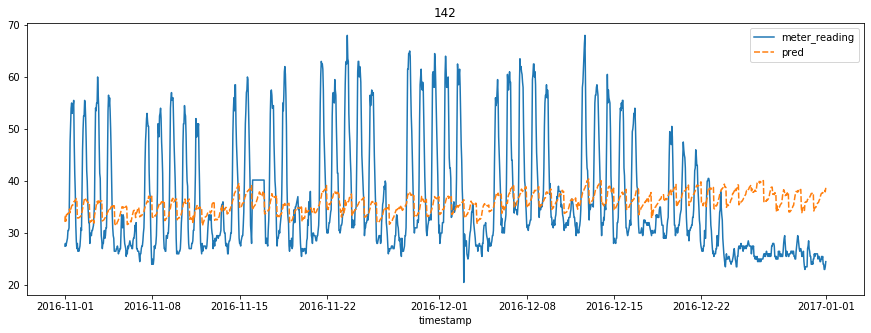

In [61]:
data=test_df.set_index('timestamp')

building_list=test_df['building_id'].unique().tolist()

for b in building_list:
  plt.figure(figsize=(15,5))
  sns.lineplot(data=data[data['building_id']==b][[target_col,'pred']]).set_title(b)



# Annexes - LSTM

In [0]:
# cf. https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_model

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  #start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
    print(end_index)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


In [41]:
TRAIN_SPLIT=np.int16(np.ceil(len(X_train)*.8))
TRAIN_SPLIT


future_target = 24*30*2 # 24 h * 30j * 2 mois  = 1440
past_history = 24*30*9 # 24h * 30j * 9 mois = 6480

#future_target = 24*5 # 24 h * 5j  = 120
#past_history = 24*5 # 24h * 5j = 120
STEP=6

5856

In [42]:
train_norm=pd.concat([pd.DataFrame(y_train),pd.DataFrame(X_train_norm)],axis=1)
test_norm=pd.concat([pd.DataFrame(y_test),pd.DataFrame(X_test_norm)],axis=1)
dataset=np.array(pd.concat([train_norm,test_norm],axis=0))
dataset.shape

(8784, 19)

In [43]:
df.shape[0]

8784

In [0]:
X_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP,single_step=False)

In [45]:
X_val_multi, y_val_multi = multivariate_data(dataset=dataset, 
                                             target=dataset[:, 0],
                                             start_index=TRAIN_SPLIT, 
                                             end_index=None, 
                                             history_size=past_history,
                                             target_size=future_target, 
                                             step=STEP,
                                             single_step=False)

7344


In [46]:
print ('Single window of past history : {}'.format(X_train_multi[0].shape))
print ('\n Target to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (1080, 19)

 Target to predict : (1440,)


In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_data_multi = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

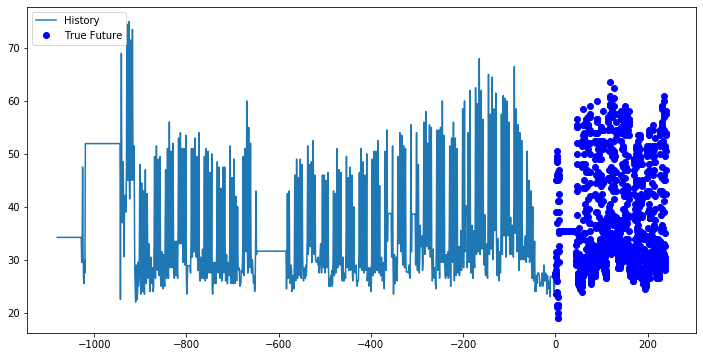

In [48]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))


In [0]:
def build_lstm_model():
  multi_step_model = tf.keras.models.Sequential()
  multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=X_train_multi.shape[-2:]))
  multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
  multi_step_model.add(tf.keras.layers.Dense(future_target))
  multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  return multi_step_model

multi_step_model=build_lstm_model()

In [50]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(32, 1440)


In [51]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 215s 1s/step - loss: 65.4264 - val_loss: 35.8359
Epoch 2/10
 98/200 [=============>................] - ETA: 1:39 - loss: 37.0767

KeyboardInterrupt: ignored

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [0]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])